# USAD

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [2]:
device = get_default_device()

In [3]:
print(device)

cuda


## EDA - Data Pre-Processing

### Download dataset

In [4]:
# Downsample
def downsample(input_arr: np.ndarray, m: int):
    '''
    Given an (n,d) numpy array, down-sample the array by calculating the median
    of every m data points

    Tested
    '''    
    # 0: calculate d
    d = input_arr.shape[1]
    # 1: cut off end
    new_len = input_arr.shape[0] - (input_arr.shape[0] % m)
    A = input_arr[0:new_len,:]
    # 2: reshape
    B = A.T
    C = B.reshape(d, -1, m)
    # 3: median
    D = np.median(C ,2)
    # 4: Reshape again
    E = D.T
    return E

### Normal period

In [5]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/tmp/ipykernel_274085/3202893291.py:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)


(495000, 51)

In [6]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [7]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [8]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,0.5,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


### Attack

In [9]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/tmp/ipykernel_274085/12158840.py:2: DtypeWarning: Columns (1,9,28,46) have mixed types. Specify dtype option on import or set low_memory=False.
  attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)


(449919, 51)

In [10]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [11]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [12]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.884144,0.577133,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944116,0.000073,0.0,0.0,0.0
1,0.891145,0.577190,1.0,1.0,0.0,0.496158,0.188845,0.064088,0.982899,1.0,...,0.970903,1.0,0.0,0.946125,0.449782,0.944521,0.000073,0.0,0.0,0.0


### Windows

In [13]:
window_size=12

In [14]:
normal_vals = downsample(normal.values, 5)
print(normal.values.shape)
print(normal_vals.shape)

attack_vals = downsample(attack.values, 5)
print(attack.values.shape)
print(attack_vals.shape)



(495000, 51)
(99000, 51)
(449919, 51)
(89983, 51)


In [15]:
windows_normal=normal_vals[np.arange(window_size)[None, :] + np.arange(normal_vals.shape[0]-window_size)[:, None]]
windows_normal.shape

(98988, 12, 51)

In [16]:
windows_attack=attack_vals[np.arange(window_size)[None, :] + np.arange(attack_vals.shape[0]-window_size)[:, None]]
windows_attack.shape

(89971, 12, 51)

## Training

In [17]:
import torch.utils.data as data_utils

BATCH_SIZE =  4096
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
#z_size=windows_normal.shape[1]*hidden_size
z_size=hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("w_size", w_size)
print("z_size", z_size)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

w_size 612
z_size 100


In [18]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0360, val_loss2: 0.0362
Epoch [1], val_loss1: 0.0323, val_loss2: -0.0020
Epoch [2], val_loss1: 0.0315, val_loss2: -0.0126
Epoch [3], val_loss1: 0.0306, val_loss2: -0.0167
Epoch [4], val_loss1: 0.0303, val_loss2: -0.0196
Epoch [5], val_loss1: 0.0304, val_loss2: -0.0213
Epoch [6], val_loss1: 0.0299, val_loss2: -0.0224
Epoch [7], val_loss1: 0.0308, val_loss2: -0.0239
Epoch [8], val_loss1: 0.0305, val_loss2: -0.0246
Epoch [9], val_loss1: 0.0309, val_loss2: -0.0256
Epoch [10], val_loss1: 0.0330, val_loss2: -0.0278
Epoch [11], val_loss1: 0.0326, val_loss2: -0.0280
Epoch [12], val_loss1: 0.0342, val_loss2: -0.0297
Epoch [13], val_loss1: 0.0330, val_loss2: -0.0291
Epoch [14], val_loss1: 0.0363, val_loss2: -0.0322
Epoch [15], val_loss1: 0.0332, val_loss2: -0.0297
Epoch [16], val_loss1: 0.0354, val_loss2: -0.0319
Epoch [17], val_loss1: 0.0337, val_loss2: -0.0306
Epoch [18], val_loss1: 0.0346, val_loss2: -0.0316
Epoch [19], val_loss1: 0.0342, val_loss2: -0.0314
Epoch [20],

KeyboardInterrupt: 

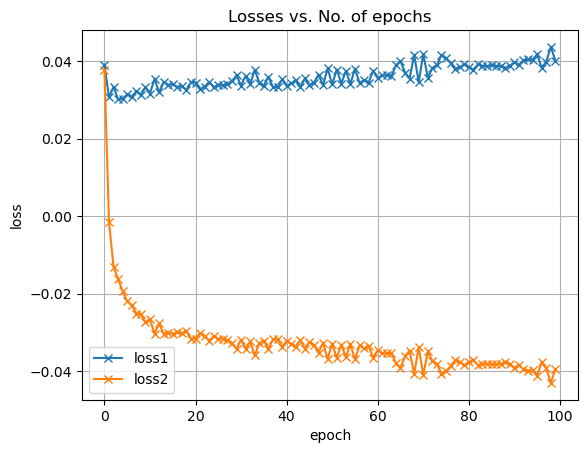

In [ ]:
plot_history(history)

In [ ]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [29]:
if 0:
    checkpoint = torch.load("model.pth")

    model.encoder.load_state_dict(checkpoint['encoder'])
    model.decoder1.load_state_dict(checkpoint['decoder1'])
    model.decoder2.load_state_dict(checkpoint['decoder2'])
else:
    checkpoint = torch.load('USAD_SWaT_model.ckpt')
    w_size = checkpoint['hp_dict']['w_size']
    z_size = checkpoint['hp_dict']['z_size']
    print("w_size", w_size)
    print("z_size", z_size)
    model = UsadModel(w_size, z_size)
    model = to_device(model,device)
    model.load_state_dict(checkpoint['model_states'])



w_size 612
z_size 100


In [30]:
results=testing(model,test_loader)
print(len(test_loader))

batch:
torch.Size([4096, 612])
tensor([0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 9.0954e-01,
        3.5425e-02, 3.8935e-01, 2.1340e-02, 9.8227e-01, 9.4383e-01, 9.6220e-01,
        9.6706e-01, 1.0000e+00, 0.0000e+00, 9.4688e-01, 4.4978e-01, 9.4493e-01,
        7.3392e-05, 0.0000e+00], device='cuda:0')
<class 'torch.Tensor'>
torch.float32
w1:
<class 'torch.Tensor'>
torch.float32
torch.Size([4096, 612])
tensor([7.2660e-01, 5.9514e-01, 8.8395e-01, 9.6525e-01, 1.5530e-04, 5.6953e-01,
        1.1429e-01, 7.0409e-02, 9.6314e-01, 9.6771e-01, 1.0147e-04, 3.4383e-04,
        9.7263e-01, 1.5606e-04, 9.0398e-01, 5.1459e-04, 9.0285e-01, 9.0582e-01,
        8.3558e-01, 4.9354e-01, 9.7987e-01, 5.1761e-01, 5.0381e-01, 3.0294e-03,
        9.6393e-01, 8.8465e-01, 1.8582e-01, 9.9692e-01, 8.9545e-01, 2.8631e-04,
        9.9776e-01, 6.4330e-04, 4.4141e-04, 9.9955e-01, 9.0893e-01, 1.9651e-01,
        4.6907e-01, 1.9009e-02, 9.8754e-01, 9.3871e-01, 9.7905e-01, 9.9573e-01,
        9.9934e-0

In [41]:

print(len(results))
for i in range(len(results)):
    plt.plot(results[i].to('cpu'))
    plt.savefig(f'./results_{i}')
    plt.close()


22


In [32]:
windows_labels=[]
labels_vals = downsample(np.asarray(labels).reshape(-1,1), 5)
for i in range(len(labels_vals)-window_size):
    windows_labels.append(list(np.int_(labels_vals[i:i+window_size])))

In [33]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [34]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])


(89971,)


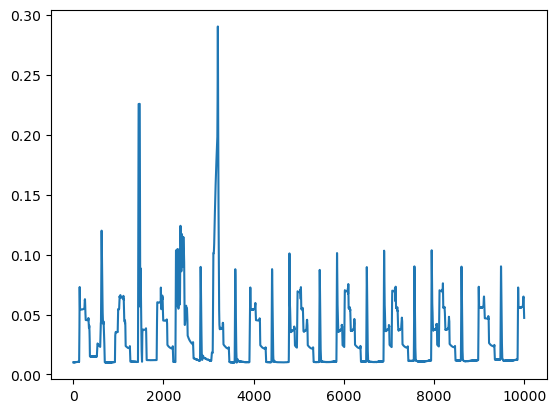

In [35]:

print(y_pred.shape)

plt.plot(y_pred[0:10000])


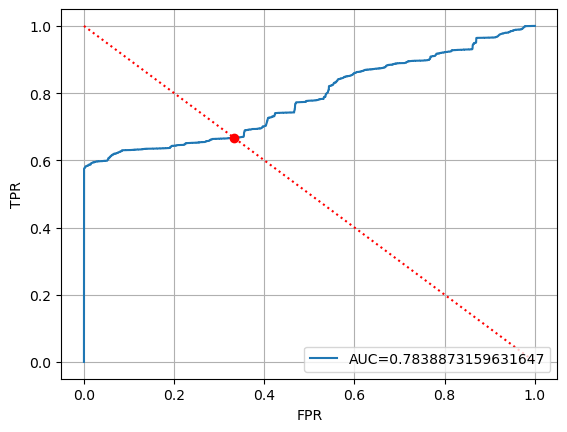

In [36]:
threshold=ROC(y_test,y_pred)